# Spike sorting

In [1]:
reAnalyse = False

## Set up everything
You shouldn't have to change anything from here so you can keep that part folded

### Load modules

In [66]:
import spikeinterface.full as si
import numpy as np
import pickle

import submitit
from memory_profiler import memory_usage
import time
import shutil
import os
from matplotlib import pyplot as plt

import asyncio
import gc

from mbTools import mbTools
from ipyfilechooser import FileChooser
import ipywidgets as widgets
from IPython.display import display
from IPython import get_ipython
import IPython
import pickleshare

%matplotlib ipympl

### Define a few variables

In [3]:
duration_extract = 2 #min

#### Structural (important for the process but no need to change)

In [4]:
last_job=None
sorter='kilosort4'

### Define a few functions

In [5]:
def update_my_expe_choice(chooser):
    currentFile = str(chooser.selected)
    mbTools.magicstore('currentFile', currentFile)

def selectData(currentFile):
    if currentFile is not None:
        pathName, fileName = os.path.split(currentFile)
    else:
        pathName = '/crnldata/waking/audrey_hay/'
        fileName = ''
    fc = FileChooser(path=pathName, filename=fileName, filter_pattern='NP_spikes_*.raw', select_default=True, show_only_dirs = False, title = "<b>Select file</b>")
    display(fc)

    # Register callback function
    fc.register_callback(update_my_expe_choice)


In [6]:
def magicretrieve(stored_var):
   # myvar will contain the variable previously stored with "%store test"
   myvar_filename = get_ipython().ipython_dir + '/profile_default/db/autorestore/' + stored_var
   with open(myvar_filename, 'rb') as f:
      return pickle.load(f)
      

In [73]:
def GenerateDict(rec, probe):
    
    # with open('/crnldata/waking/audrey_hay/NPX/NPXprobe.pkl', 'rb') as outp: 
    #     probe = pickle.load(outp)
    # probe.set_device_channel_indices(np.arange(384))

    # raw_rec = si.read_binary(file, dtype='uint16', num_channels=384, sampling_frequency=30_000.)
    # raw_rec = raw_rec.set_probe(probe)
    # raw_rec = raw_rec.frame_slice(0, 30_000 * 60 * duration_extract)
    
    rec = rec.set_probe(probe)
    sorting = si.run_sorter(sorter, rec, verbose=True, remove_existing_folder=True)
    return sorting


In [8]:
def runFullSpikeSorting(file, sorting):
    dirpath = os.path.join(os.getcwd(), 'sorting_analyzer_demo_K')
    if os.path.exists(dirpath) and os.path.isdir(dirpath):
        shutil.rmtree(dirpath)
        print(f'{dirpath} existed so it was deleted')

    with open('/crnldata/waking/audrey_hay/NPX/NPXprobe.pkl', 'rb') as outp: 
        probe = pickle.load(outp)
    probe.set_device_channel_indices(np.arange(384))

    raw_rec = si.read_binary(file, dtype='uint16', num_channels=384, sampling_frequency=30_000.)
    raw_rec = raw_rec.set_probe(probe)

    rec = raw_rec.astype('float32')
    rec = si.bandpass_filter(rec)
    rec = si.common_reference(rec)
    rec.get_dtype()

    si.set_global_job_kwargs(n_jobs=40, progress_bar=True, chunk_duration="1s")

    sorting_analyzer = si.create_sorting_analyzer(sorting, rec, sparse=True)

    job_kwargs = dict(n_jobs=40, progress_bar=True, chunk_duration="1s")

    sorting_analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
    sorting_analyzer.compute("waveforms", **job_kwargs)
    sorting_analyzer.compute("templates", **job_kwargs)
    sorting_analyzer.compute("noise_levels")
    sorting_analyzer.compute("unit_locations", method="monopolar_triangulation")
    sorting_analyzer.compute("isi_histograms")
    sorting_analyzer.compute("correlograms", window_ms=100, bin_ms=5.)
    sorting_analyzer.compute("principal_components", n_components=3, mode='by_channel_global', whiten=True, **job_kwargs)
    sorting_analyzer.compute("quality_metrics", metric_names=["snr", "firing_rate"])
    sorting_analyzer.compute("template_similarity")
    sorting_analyzer.compute("spike_amplitudes", **job_kwargs)


    sorting_analyzer.save_as(folder='./sorting_analyzer_demo_K', format='binary_folder')

In [9]:
def checkRessources():
    # check node and CPU information
    print("### Node counts: \nA: currently in use \B available")
    !sinfo -o%A
    print("### CPU counts: \nA: core currently in use \nI: available \nO: unavailable (maintenance, down, etc) \nT: total")
    !sinfo -o%C
    !sinfo

    # check some stats of our last job
    if last_job is not None:
        print('### CPU time and MaxRSS of our last job (about 1000Mb should be added to your MaxRSS (Mb) in order to cover safely the memory needs of the python runtime)###')
        os.system(f'sacct -j {last_job.job_id} --format="CPUTime,MaxRSS"')

## Choose data

In [10]:

#currentFile = '/crnldata/waking/audrey_hay/NPX/NPX1/VB/Expe_2024-07-22_17-55-16/NP_spikes_2024-07-22T17_55_16.raw'
currentFile = magicretrieve('currentFile')
selectData(currentFile)

FileChooser(path='/mnt/data/ahay', filename='NP_spikes_2024-07-22T17_55_16.raw', title='<b>Select file</b>', s…

### Move data to /mnt/ if appropriate

In [11]:
# check location of file
currentFile = magicretrieve('currentFile')
if not currentFile.startswith('/mnt/'):
    src = currentFile
    dst = os.path.join('/mnt/data/ahay',os.path.split(currentFile)[1])
    print(f'the selected file {currentFile} is not on /mnt/')

    # check if the file already exists on /mnt/
    if os.path.isfile(dst):
        print(f"but {dst} already exists so making it the currentFile to use")
        currentFile = dst
        mbTools.magicstore('currentFile', currentFile)
    else:
        print("and there is no version on /mnt/")
        shouldCopy = False # it took a while (20 min for a file of about 150Gb)
        if shouldCopy:
            print(f'it will be copied to {dst}')
            startTime = time.time()
            shutil.copyfile(src, dst)
            print(f'the transfer is complete, it took {time.time()-startTime} seconds')
            currentFile = dst
            mbTools.magicstore('currentFile', currentFile)
        else:
            print('it can be transfered from here by changing the shouldCopy parameter but probably best not to because it takes a while and uses massive ressources')
else:
    print(f'the file {currentFile} is already on /mnt/ so all is well')


the file /mnt/data/ahay/NP_spikes_2024-07-22T17_55_16.raw is already on /mnt/ so all is well


### Lazy load data and probe

In [45]:
currentFile = magicretrieve('currentFile')

raw_rec = si.read_binary(currentFile, dtype='uint16', num_channels=384, sampling_frequency=30_000.)
display(raw_rec)


BinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 189,418,428 samples 
                          6,313.95s (1.75 hours) - uint16 dtype - 135.48 GiB
  file_paths: ['/mnt/data/ahay/NP_spikes_2024-07-22T17_55_16.raw']

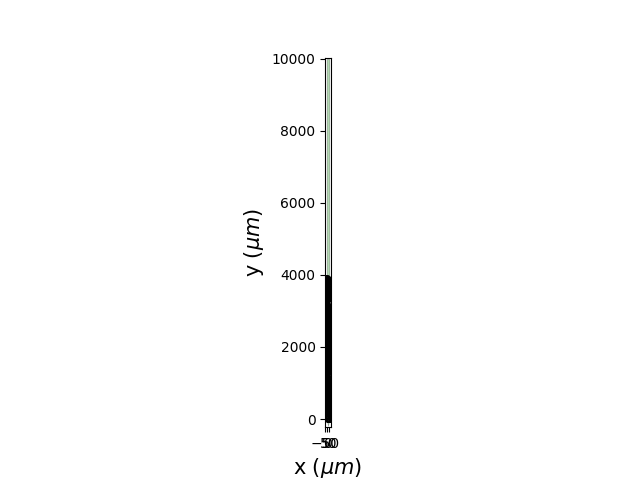

In [67]:
with open('/crnldata/waking/audrey_hay/NPX/NPXprobe.pkl', 'rb') as outp: 
    probe = pickle.load(outp)
probe.set_device_channel_indices(np.arange(384))

raw_rec = raw_rec.set_probe(probe)
display(si.plot_probe_map(raw_rec, with_channel_ids=True))

## PreProcessing

### Lazy preprocessing

In [61]:
# filter traces
rec = raw_rec.astype('float32')
rec_filt = si.bandpass_filter(rec)
display(rec_filt)

BandpassFilterRecording: 384 channels - 30.0kHz - 1 segments - 189,418,428 samples 
                         6,313.95s (1.75 hours) - float32 dtype - 270.97 GiB

In [62]:
# Remove bad channels
try:
    bad_channel_ids, channel_labels = si.detect_bad_channels(rec_filt)
    print('bad_channel_ids', bad_channel_ids)
    rec_filt = rec_filt.remove_channels(bad_channel_ids)
except Exception as error:
    print("could not remove bad channels because there was an error:")
    print(error)

could not remove bad channels because there was an error:
The 'coherence+psd' method uses thresholds assuming the traces are in uV, but the recording does not have scaled traces. If the recording is already scaled, you need to set gains and offsets: >>> recording.set_channel_gains(1); recording.set_channel_offsets(0)


In [63]:
#rec_filt2 = si.phase_shift(rec_filt) # I don't know what is the purpose of this
rec_filt_ref = si.common_reference(rec_filt)
display(rec_filt_ref)

CommonReferenceRecording: 384 channels - 30.0kHz - 1 segments - 189,418,428 samples 
                          6,313.95s (1.75 hours) - float32 dtype - 270.97 GiB

### Visualize preprocessing

In [65]:
si.plot_traces({'filter':rec_filt, 'cmr': rec_filt_ref}, backend='ipywidgets') #, mode='line'

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

### Initial checks

Text(0.5, 0, 'noise  [?]')

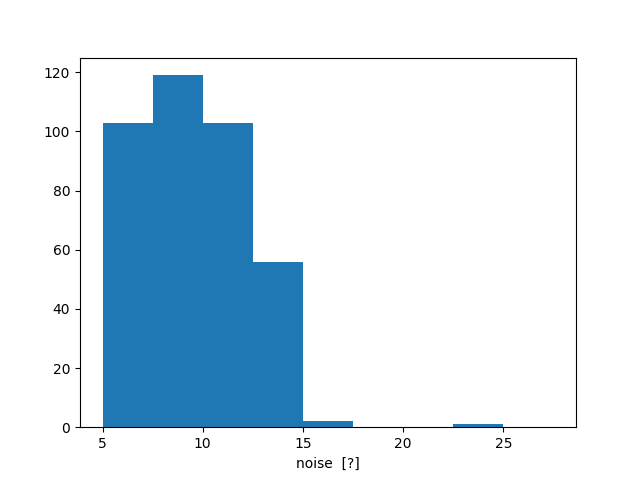

In [60]:
#noise_levels_microV = si.get_noise_levels(rec_filt_ref, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(rec_filt_ref, return_scaled=False)

fig, ax = plt.subplots()
_ = ax.hist(noise_levels_int16, bins=np.arange(5, 30, 2.5))
ax.set_xlabel('noise  [?]')

In [68]:
#check drift = takes about 10min
job_kwargs = dict(n_jobs=40, progress_bar=True, chunk_duration="1s")
recording_corrected, motion, motion_info = si.correct_motion(
        rec_filt_ref, preset="dredge", folder=None, output_motion=True, output_motion_info=True, **job_kwargs
    )
display(motion)

detect and localize:   0%|          | 0/6314 [00:00<?, ?it/s]

Cross correlation:   0%|          | 0/9 [00:00<?, ?it/s]

Solve:   0%|          | 0/8 [00:00<?, ?it/s]

Motion non-rigid - 9 spatial bins - interval 1.0s - 1 segments

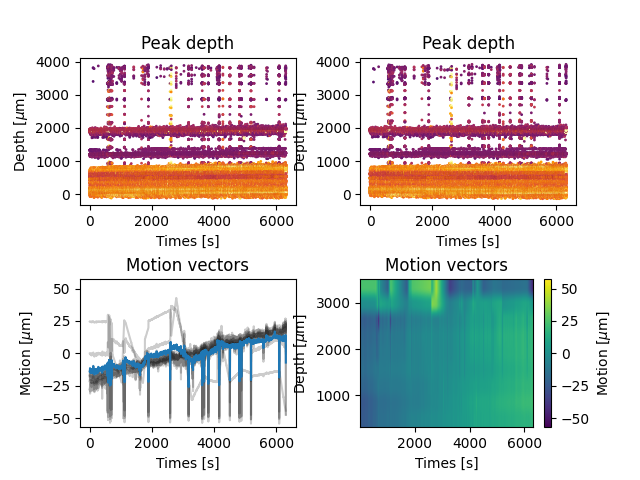

In [69]:
si.plot_motion_info(motion_info, rec_filt_ref,
                   color_amplitude=True,
        amplitude_cmap="inferno",)

## Identify spike clusters for the first few minutes of recording

It is good practice to have a look at available ressources and current use of the cluster

In [38]:
checkRessources()

!sinfo --nodes=node15 -o "%50N  %10c  %20m  %30G "
!squeue --partition="GPU"

#torch.OutOfMemoryError: CUDA out of memory. Tried to allocate 712.00 MiB. GPU 0 has a total capacity of 79.26 GiB of which 187.19 MiB is free. Process 1619368 has 77.78 GiB memory in use. Including non-PyTorch memory, this process has 1.28 GiB memory in use. Of the allocated memory 529.55 MiB is allocated by PyTorch, and 276.45 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


### Node counts: 
A: currently in use \B available
NODES(A/I)
17/3
### CPU counts: 
A: core currently in use 
I: available 
O: unavailable (maintenance, down, etc) 
T: total
CPUS(A/I/O/T)
70/866/64/1000
PARTITION   AVAIL  TIMELIMIT  NODES  STATE NODELIST
CPU*           up   infinite      1  drain node14
CPU*           up   infinite     16    mix node[2-11,13,15,18-21]
INTERACTIVE    up   infinite      3   idle node[12,16-17]
GPU            up   infinite      1    mix node23
NODELIST                                            CPUS        MEMORY                GRES                           
node15                                              64          128635                (null)                         
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
             34241       GPU 3_add_co pauline. PD       0:00      1 (Resources)
             34240       GPU 2_add_co pauline.  R    2:24:35      1 node23
             34239       GPU add_cont pauline

In [13]:

params = si.get_default_sorter_params(sorter_name_or_class=sorter)
print(f"For information, parameters that are available for the sorter {sorter} are:\n", params)

For information, parameters that are available for the sorter kilosort4 are:
 {'batch_size': 60000, 'nblocks': 1, 'Th_universal': 9, 'Th_learned': 8, 'do_CAR': True, 'invert_sign': False, 'nt': 61, 'shift': None, 'scale': None, 'artifact_threshold': None, 'nskip': 25, 'whitening_range': 32, 'highpass_cutoff': 300, 'binning_depth': 5, 'sig_interp': 20, 'drift_smoothing': [0.5, 0.5, 0.5], 'nt0min': None, 'dmin': None, 'dminx': 32, 'min_template_size': 10, 'template_sizes': 5, 'nearest_chans': 10, 'nearest_templates': 100, 'max_channel_distance': None, 'templates_from_data': True, 'n_templates': 6, 'n_pcs': 6, 'Th_single_ch': 6, 'acg_threshold': 0.2, 'ccg_threshold': 0.25, 'cluster_downsampling': 20, 'cluster_pcs': 64, 'x_centers': None, 'duplicate_spike_ms': 0.25, 'scaleproc': None, 'save_preprocessed_copy': False, 'torch_device': 'auto', 'bad_channels': None, 'clear_cache': False, 'save_extra_vars': False, 'do_correction': True, 'keep_good_only': False, 'skip_kilosort_preprocessing': Fa

In [75]:
reAnalyse = True
if reAnalyse:
    #it takes about 90s with GPU (if available) ; 40 min otherwise
    gc.collect()

    GPU_available = True

    start_time = time.time()
    rec_filt_ref_slice = rec_filt_ref.frame_slice(0, 30_000 * 60 * duration_extract)

    executor = submitit.AutoExecutor(folder=os.getcwd()+'/si_logs/')
    if GPU_available:
        executor.update_parameters(mem_gb=5, timeout_min=10, slurm_partition="GPU", cpus_per_task=2)
        #executor.update_parameters(mem_gb=5, timeout_min=5, slurm_partition="GPU", slurm_gres='gpu:1')
    else:
        executor.update_parameters(mem_gb=5, timeout_min=120, slurm_partition="CPU", cpus_per_task=60)


    # actually submit the job
    job = executor.submit(GenerateDict, rec_filt_ref_slice, probe)

    # print the ID of your job
    print("submit job" + str(job.job_id))  

    # await a single result
    await job.awaitable().results()
    print(f"job {job.job_id} completed in " + str(time.time()-start_time) + " seconds")

    last_job = job
    sorting = job.result()
    display(sorting)

submit job34289
job 34289 completed in 291.7337501049042 seconds


KiloSortSortingExtractor: 244 units - 1 segments - 30.0kHz

In [15]:
#kilosort4 run time 2212.34s for 8Gb 10cpus num1 (15.74, 15.42, 1.49, 2.11)
#100%|██████████| 60/60 [39:44<00:00, 39.74s/it] 8/10 python

#32%|███▏      | 19/60 [09:26<19:40, 28.78s/it] 8/30 submitit
#32%|███▏      | 19/60 [09:13<19:55, 29.16s/it] 16/30 submitit
#60%|██████    | 36/60 [12:10<07:36, 19.02s/it] 5/30 submitit
#23%|██▎       | 14/60 [10:14<32:55, 42.95s/it] 5/10 submitit
#42%|████▏     | 25/60 [06:35<07:23, 12.66s/it] 5/50 submitit
#33%|███▎      | 20/60 [05:32<10:29, 15.75s/it] 5/50 submitit data in mnt


#GPU
#job completed: 33972 returned in 110.73936009407043 seconds 5/50
#job completed: 33973 returned in 94.93399000167847 seconds 5/10
#job completed: 33975 returned in 93.79518842697144 seconds 5/2

In [16]:
if not reAnalyse:
    sorterFolder='kilosort4_output'
    if os.path.isdir(sorterFolder):
        # directory exists
        print(f"the previous folder {sorterFolder} was found, importing the data")
        sorting = si.read_sorter_folder(sorterFolder)
        display(sorting)
    else:
        print(f"the folder {sorterFolder} does not exist ; make sure of the path or reAnalyse the data")


the previous folder kilosort4_output was found, importing the data


KiloSortSortingExtractor: 233 units - 1 segments - 30.0kHz

## Sort full recording

In [ ]:
print(sorting)

start_time = time.time()
mem_usage=memory_usage((runFullSpikeSorting,(currentFile,sorting)))
end_time = time.time()
print('Maximum memory usage (in MB): %s' % max(mem_usage))
print('Maximum memory usage (in GB): %s' % (max(mem_usage)/1000))
print('Time taken (in s): %s' % (end_time-start_time))

In [ ]:
start_time = time.time()

executor = submitit.AutoExecutor(folder=os.getcwd()+'/si_logs/')
#executor.update_parameters(slurm_array_parallelism=2, mem_gb=30, timeout_min=10, slurm_partition="CPU", cpus_per_task=50)
executor.update_parameters(mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=70) #cpus_per_task

# actually submit the job
job = executor.submit(runFullSpikeSorting, currentFile, sorting)

# print the ID of your job
print("submit job" + str(job.job_id))  

# await a single result
await job.awaitable().results()
print(f"job {job.job_id} completed in " + str(time.time()-start_time) + " seconds")

In [ ]:
#job 34074 completed in 408.1813361644745 second (slurm_array_parallelism=2, mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=50)
#job 34078 completed in 437.409494638443 seconds (slurm_array_parallelism=3, mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=50)
#job 34081 completed in 423.37460565567017 seconds (slurm_array_parallelism=2, mem_gb=60, timeout_min=20, slurm_partition="GPU", slurm_gres="gpu:2", cpus_per_task=50)
#job 34085 completed in 367.0000305175781 seconds (slurm_array_parallelism=2, mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=70)
#job 34089 completed in 370.1982145309448 seconds (slurm_array_parallelism=2, mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=80)
#job 34093 completed in 355.1876621246338 seconds (mem_gb=60, timeout_min=20, slurm_partition="GPU", cpus_per_task=70)

last_job = job
checkRessources()

## Cure the clusters
Here you should ensure that you are happy with the clusters that were found. You have 2 solutions for that:
1. either go on a local script (not over ssh), reload the sorter Folder (read_sorter_folder), and visualize everything on a gui
1. or use the following embedded plotting widget

In [19]:
# not to use over ssh as it will crash the kernel
if False:
    %gui qt
    si.plot_sorting_summary(sorting, backend="spikeinterface_gui")

In [20]:
%matplotlib widget
print("youhou")


youhou
